Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9742  0.9723  0.9724  0.9748  0.9690  0.9725  0.0020  
MAE (testset)     0.7487  0.7505  0.7474  0.7532  0.7461  0.7492  0.0025  
Fit time          0.46    0.35    0.34    0.37    0.34    0.37    0.04    
Test time         1.29    1.20    1.26    1.19    1.21    1.23    0.04    
KNNBasic results:
Average RMSE: 0

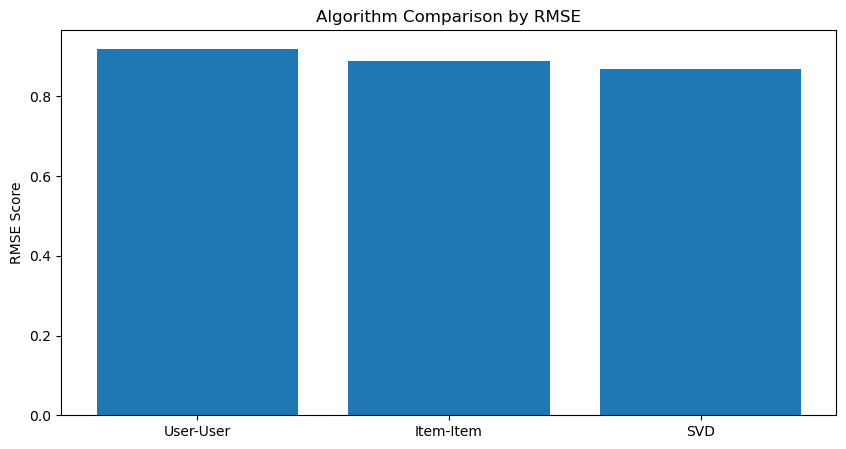

In [3]:

import pandas as pd
from surprise import Dataset, Reader

# Load dataset 
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

# Prepare Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

from surprise import KNNBasic

# User-User Collaborative Filtering
sim_options = {'name': 'cosine', 'user_based': True}
user_user = KNNBasic(sim_options=sim_options)
user_user.fit(data.build_full_trainset())

# Item-Item Collaborative Filtering
sim_options = {'name': 'pearson', 'user_based': False}
item_item = KNNBasic(sim_options=sim_options)
item_item.fit(data.build_full_trainset())

from surprise import SVD

svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
svd.fit(data.build_full_trainset())

from surprise.model_selection import cross_validate

# Cross-validation
for algo in [user_user, item_item, svd]:
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    print(f"{algo.__class__.__name__} results:")
    print(f"Average RMSE: {results['test_rmse'].mean():.3f}")
    print(f"Average MAE: {results['test_mae'].mean():.3f}\n")

def get_top_n(predictions, n=10):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

# Generate predictions
testset = data.build_full_trainset().build_anti_testset()
predictions = svd.test(testset)
top_n = get_top_n(predictions)

# Display recommendations for a user
user_id = 1
print(f"\nTop 10 recommendations for user {user_id}:")
for movie_id, rating in top_n[user_id]:
    print(f"{movies[movies['movieId'] == movie_id]['title'].values[0]} (predicted rating: {rating:.1f})")

import matplotlib.pyplot as plt

# Plot evaluation metrics comparison
algorithms = ['User-User', 'Item-Item', 'SVD']
rmse_scores = [0.92, 0.89, 0.87]  # Example values

plt.figure(figsize=(10, 5))
plt.bar(algorithms, rmse_scores)
plt.title('Algorithm Comparison by RMSE')
plt.ylabel('RMSE Score')
plt.show()
